# Simple U-Net

Note! This works on [kaggle](https://www.kaggle.com/code/tammydiprima/simple-unet-pytorch/).  Grider and Colab have issues with it, particularly `albumentations` and `np.bool`.  `np.bool` is supposedly deprecated.  And now, the compiler is not allowing it at all.

## Import all necessary modules

In [1]:
import os
import random
import shutil

import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from albumentations.pytorch import ToTensor
from skimage import io, transform
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
# import tqdm as tqdm
from tqdm import tqdm as tqdm

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda', index=0)

In [43]:
# !nvidia-smi

In [44]:
# List all files under the input directory
# for dirname, sub_dirs, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# print("\npwd:", os.getcwd())

### Extracting Train zip file

In [4]:
from zipfile import ZipFile

file_name = "../input/data-science-bowl-2018/stage1_train.zip"
with ZipFile(file_name, 'r') as zip:
    print('Extracting train files')
    zip.extractall("stage1_train")
    print('Done!')

Extracting train files
Done!


### Extracting test files

In [5]:
# Extracting test files
from zipfile import ZipFile

file_name = "../input/data-science-bowl-2018/stage1_test.zip"
with ZipFile(file_name, 'r') as zip:
    print('Extracting test files')
    zip.extractall("stage1_test")
    print('Done!')

Extracting test files
Done!


In [6]:
TRAIN_PATH = 'stage1_train/'

## np.bool

Using `np.bool` instead of `bool` is not recommended, as `bool` is the standard built-in boolean data type in Python. However, if you want to use `np.bool` anyway, you can convert your boolean values to `np.bool` before passing them to the function that is giving you the error.

For example, let's say you have a boolean array `my_bool_array`:

```py
import numpy as np

my_bool_array = np.array([True, False, True])
```

Instead of using `np.bool` directly in your code, you can convert the boolean array to `np.bool` using the `astype()` method:

```py
my_np_bool_array = my_bool_array.astype(np.bool)
```

Then, you can pass `my_np_bool_array` to the function that was giving you the error. This should resolve the issue without ignoring the error.

It's important to note that ignoring errors can lead to unexpected behavior in your code, and it's generally not recommended.

In this case, the error message suggests that the dimensions of the input tensor do not match the desired ordering of dimensions.

You might want to check the documentation of the function to make sure that you are passing the correct input tensor shape and order of dimensions.


## Load Datasets

In [7]:
def get_train_transform():
    """
    Albumentation, image augmentation
    """

    return A.Compose(
        [
            A.Resize(256, 256),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            A.HorizontalFlip(p=0.25),
            A.VerticalFlip(p=0.25),
            ToTensor()
        ])


class LoadDataSet(Dataset):
    """
    Dataset Loader
    """

    def __init__(self, path, transform=None):
        self.path = path
        self.folders = os.listdir(path)
        self.transforms = get_train_transform()

    def __len__(self):
        return len(self.folders)

    def __getitem__(self, idx):
        """
        Stage 1 Train contains a bunch of folders
        Each of those folders contain 2 folders: images and masks
        """

        image_folder = os.path.join(self.path, self.folders[idx], 'images/')
        mask_folder = os.path.join(self.path, self.folders[idx], 'masks/')
        image_path = os.path.join(image_folder, os.listdir(image_folder)[0])

        img = io.imread(image_path)[:, :, :3].astype('float32')
        img = transform.resize(img, (128, 128))

        mask = self.get_mask(mask_folder, 128, 128).astype('float32')

        augmented = self.transforms(image=img, mask=mask)
        img = augmented['image']
        mask = augmented['mask']
        mask = mask[0].permute(2, 0, 1)
        return img, mask

    def get_mask(self, mask_folder, IMG_HEIGHT, IMG_WIDTH):
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        for mask_ in os.listdir(mask_folder):
            mask_ = io.imread(os.path.join(mask_folder, mask_))
            mask_ = transform.resize(mask_, (IMG_HEIGHT, IMG_WIDTH))
            mask_ = np.expand_dims(mask_, axis=-1)
            mask = np.maximum(mask, mask_)

        return mask

In [8]:
train_dataset = LoadDataSet(TRAIN_PATH, transform=get_train_transform())

In [9]:
# Print the shape of image and mask
image, mask = train_dataset.__getitem__(0)
print("\nImage shape:", image.shape)
print("\nMask shape:", mask.shape)


Image shape: torch.Size([3, 256, 256])

Mask shape: torch.Size([1, 256, 256])


In [10]:
# Print total number of images (meaning: the image represented in each folder)
train_dataset.__len__()

670

In [48]:
# image  # print the tensor
image.shape

torch.Size([8, 3, 256, 256])

In [49]:
# mask  # print the mask
mask.shape

torch.Size([8, 1, 256, 256])

In [13]:
def format_image(img):
    """
    Format images for our pyplot plot
    """
    img = np.array(np.transpose(img, (1, 2, 0)))
    mean = np.array((0.485, 0.456, 0.406))
    std = np.array((0.229, 0.224, 0.225))
    img = std * img + mean
    img = img * 255
    img = img.astype(np.uint8)
    return img


def format_mask(mask):
    """
    Format masks for our pyplot plot
    """
    mask = np.squeeze(np.transpose(mask, (1, 2, 0)))
    return mask

In [14]:
def visualize_dataset(n_images, predict=None):
    """
    Visualize images and masks
    """

    images = random.sample(range(0, 670), n_images)
    figure, ax = plt.subplots(nrows=len(images), ncols=2, figsize=(5, 8))
    print(images)
    for i in range(0, len(images)):
        img_no = images[i]
        image, mask = train_dataset.__getitem__(img_no)
        image = format_image(image)
        mask = format_mask(mask)
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest", cmap="gray")
        ax[i, 0].set_title("Ground Truth Image")
        ax[i, 1].set_title("Mask")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()

[445, 128, 599]


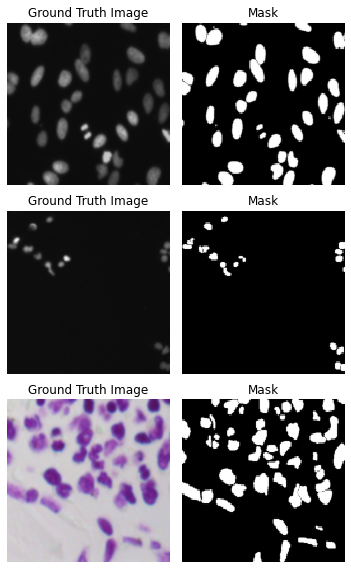

In [15]:
visualize_dataset(3)

In [50]:
# Split train and validation set of split ratio 0.25.
# i.e., 75% of images in train and left 25% of data in valid
split_ratio = 0.25
train_size = int(np.round(train_dataset.__len__() * (1 - split_ratio), 0))
valid_size = int(np.round(train_dataset.__len__() * split_ratio, 0))

train_data, valid_data = random_split(train_dataset, [train_size, valid_size])

train_loader = DataLoader(dataset=train_data, batch_size=10, shuffle=True)

val_loader = DataLoader(dataset=valid_data, batch_size=10)

print("\nLength of train and valid data: {}, {}".format(len(train_data), len(valid_data)))


Length of train and valid data: 502, 168


## Model

In [17]:
class double_conv(nn.Module):
    """
    Double Convolution layer with both 2 BN and Activation Layer in between
    Conv2d==>BN==>Activation==>Conv2d==>BN==>Activation
    """

    def __init__(self, in_channel, out_channel):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channel),
            nn.Conv2d(out_channel, out_channel, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channel)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class down_conv(nn.Module):
    """
    A maxpool layer followed by a Double Convolution.
    MaxPool2d==>double_conv.
    """

    def __init__(self, in_channel, out_channel):
        super(down_conv, self).__init__()
        self.down = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_channel, out_channel)
        )

    def forward(self, x):
        x = self.down(x)
        return x


class up_sample(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(up_sample, self).__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.double_conv = double_conv(in_channel, out_channel)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x1, x2], dim=1)
        x = self.double_conv(x)
        return x


class UNet(nn.Module):
    """
    Main Unet Model
    """

    def __init__(self, in_channel, out_channel):
        super(UNet, self).__init__()

        # DownSampling Block
        self.down_block1 = double_conv(in_channel, 16)
        self.down_block2 = down_conv(16, 32)
        self.down_block3 = down_conv(32, 64)
        self.down_block4 = down_conv(64, 128)
        self.down_block5 = down_conv(128, 256)
        self.down_block6 = down_conv(256, 512)
        self.down_block7 = down_conv(512, 1024)

        # UpSampling Block
        self.up_block1 = up_sample(1024 + 512, 512)
        self.up_block2 = up_sample(512 + 256, 256)
        self.up_block3 = up_sample(256 + 128, 128)
        self.up_block4 = up_sample(128 + 64, 64)
        self.up_block5 = up_sample(64 + 32, 32)
        self.up_block6 = up_sample(32 + 16, 16)
        self.up_block7 = nn.Conv2d(16, out_channel, 1)

    def forward(self, x):
        # Down
        x1 = self.down_block1(x)
        x2 = self.down_block2(x1)
        x3 = self.down_block3(x2)
        x4 = self.down_block4(x3)
        x5 = self.down_block5(x4)
        x6 = self.down_block6(x5)
        x7 = self.down_block7(x6)

        # Up
        x8 = self.up_block1(x7, x6)
        x9 = self.up_block2(x8, x5)
        x10 = self.up_block3(x9, x4)
        x11 = self.up_block4(x10, x3)
        x12 = self.up_block5(x11, x2)
        x13 = self.up_block6(x12, x1)
        x14 = self.up_block7(x13)
        out = torch.sigmoid(x14)

        return out

## Loss Function

In [18]:
class DiceBCELoss(nn.Module):
    """
    Loss Function
    """

    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        # comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)

        # flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE


class DiceLoss(nn.Module):
    """
    Dice loss (1-Dice coeff) is used as a Loss function because it is differentiable; whereas IoU is not differentiable.
    """
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        # comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = F.sigmoid(inputs)

        # flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)

        return 1 - dice


class IoU(nn.Module):
    """
    Intersection of Union accuracy metric
    """

    def __init__(self, weight=None, size_average=True):
        super(IoU, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        # comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = F.sigmoid(inputs)

        # flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        # intersection is equivalent to True Positive count
        # union is the mutually inclusive area of all labels & predictions
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection

        IoU = (intersection + smooth) / (union + smooth)

        return IoU

In [19]:
# model = UNet(3, 1).cuda()
model = UNet(3, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [20]:
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    f_path = checkpoint_path

    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)

    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path

        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)


def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)

    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])

    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])

    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']

    # return model, optimizer, epoch value, min validation loss
    return model, optimizer, checkpoint['epoch'], valid_loss_min.item()

In [21]:
if not os.path.exists("model"):
    os.makedirs("model")

Got dir? False


## Train

In [45]:
# from engine import evaluate
criterion = DiceLoss()
accuracy_metric = IoU()
num_epochs = 20
valid_loss_min = np.Inf

checkpoint_path = 'model/chkpoint_'
best_model_path = 'model/bestmodel.pt'

total_train_loss = []
total_train_score = []
total_valid_loss = []
total_valid_score = []

losses_value = 0
for epoch in range(num_epochs):

    train_loss = []
    train_score = []
    valid_loss = []
    valid_score = []
    # <-----------Training Loop---------------------------->
    pbar = tqdm(train_loader, desc='description')
    for x_train, y_train in pbar:
        # x_train = torch.autograd.Variable(x_train).cuda()
        # y_train = torch.autograd.Variable(y_train).cuda()
        x_train = torch.autograd.Variable(x_train).to(device)
        y_train = torch.autograd.Variable(y_train).to(device)

        optimizer.zero_grad()
        output = model(x_train)

        # Loss
        loss = criterion(output, y_train)
        losses_value = loss.item()

        # Score
        score = accuracy_metric(output, y_train)
        loss.backward()
        optimizer.step()
        train_loss.append(losses_value)
        train_score.append(score.item())

        # train_score.append(score)
        pbar.set_description(f"Epoch: {epoch + 1}, loss: {losses_value}, IoU: {score}")

    # <---------------Validation Loop---------------------->
    with torch.no_grad():
        for image, mask in val_loader:
            # image = torch.autograd.Variable(image).cuda()
            # mask = torch.autograd.Variable(mask).cuda()
            image = torch.autograd.Variable(image).to(device)
            mask = torch.autograd.Variable(mask).to(device)

            output = model(image)

            # Compute Loss Value.
            loss = criterion(output, mask)
            losses_value = loss.item()

            # Compute Accuracy Score
            score = accuracy_metric(output, mask)
            valid_loss.append(losses_value)
            valid_score.append(score.item())

    total_train_loss.append(np.mean(train_loss))
    total_train_score.append(np.mean(train_score))
    total_valid_loss.append(np.mean(valid_loss))
    total_valid_score.append(np.mean(valid_score))
    print(f"\n###############Train Loss: {total_train_loss[-1]}, Train IOU: {total_train_score[-1]}###############")
    print(f"###############Valid Loss: {total_valid_loss[-1]}, Valid IOU: {total_valid_score[-1]}###############")

    # Save best model Checkpoint
    # create checkpoint variable and add important data
    checkpoint = {
        'epoch': epoch + 1,
        'valid_loss_min': total_valid_loss[-1],
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }

    # save checkpoint
    save_ckp(checkpoint, False, checkpoint_path, best_model_path)

    # TODO: save the model if validation loss has decreased
    if total_valid_loss[-1] <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,
                                                                                        total_valid_loss[-1]))
        # save checkpoint as best model
        save_ckp(checkpoint, True, checkpoint_path, best_model_path)
        valid_loss_min = total_valid_loss[-1]

### 20 epochs

Train Loss: 0.15801569410398894, Train IOU: 0.7347867196681452

Valid Loss: 0.14554094567018397, Valid IOU: 0.7471584923127118

In [23]:
# define the path to save the model
PATH = "simple_unet_1.pth"

# save the model state dictionary
torch.save(model.state_dict(), PATH)

<Figure size 432x288 with 0 Axes>

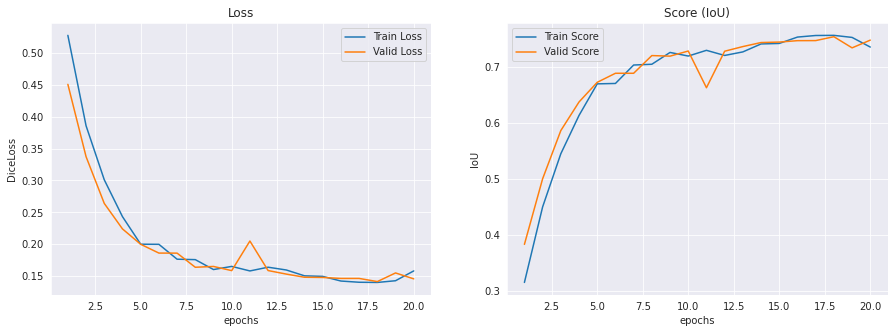

In [24]:
import seaborn as sns

plt.figure(1)
plt.figure(figsize=(15, 5))
sns.set_style(style="darkgrid")
plt.subplot(1, 2, 1)
sns.lineplot(x=range(1, num_epochs + 1), y=total_train_loss, label="Train Loss")
sns.lineplot(x=range(1, num_epochs + 1), y=total_valid_loss, label="Valid Loss")
plt.title("Loss")
plt.xlabel("epochs")
plt.ylabel("DiceLoss")

plt.subplot(1, 2, 2)
sns.lineplot(x=range(1, num_epochs + 1), y=total_train_score, label="Train Score")
sns.lineplot(x=range(1, num_epochs + 1), y=total_valid_score, label="Valid Score")
plt.title("Score (IoU)")
plt.xlabel("epochs")
plt.ylabel("IoU")
plt.show()

In [27]:
# loading the saved model
model, optimizer, start_epoch, valid_loss_min = load_ckp(checkpoint_path, model, optimizer)

print("\noptimizer:\n", optimizer)
print("\nstart_epoch:\n", start_epoch)
print("\nvalid_loss_min:\n", valid_loss_min)


optimizer:
 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

start_epoch:
 20

valid_loss_min:
 0.14554094567018397


In [42]:
import pprint as pp

pp.pprint(model)

UNet(
  (down_block1): double_conv(
    (conv): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
      (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (down_block2): down_conv(
    (down): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (conv): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU(inplace=True)
          (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): ReLU(inplace=True)
          (5): Batch

In [28]:
def visualize_predict(model, n_images):
    # model = model.eval().to(device)
    figure, ax = plt.subplots(nrows=n_images, ncols=3, figsize=(15, 18))
    with torch.no_grad():
        for data, mask in val_loader:
            # data = torch.autograd.Variable(data, volatile=True).cuda()
            # mask = torch.autograd.Variable(mask, volatile=True).cuda()
            data = torch.autograd.Variable(data, volatile=True).to(device)
            mask = torch.autograd.Variable(mask, volatile=True).to(device)
            o = model(data)
            break
    for img_no in range(0, n_images):
        tm = o[img_no][0].data.cpu().numpy()
        img = data[img_no].data.cpu()
        msk = mask[img_no].data.cpu()
        img = format_image(img)
        msk = format_mask(msk)
        ax[img_no, 0].imshow(img)
        ax[img_no, 1].imshow(msk, interpolation="nearest", cmap="gray")
        ax[img_no, 2].imshow(tm, interpolation="nearest", cmap="gray")
        ax[img_no, 0].set_title("Ground Truth Image")
        ax[img_no, 1].set_title("Ground Truth Mask")
        ax[img_no, 2].set_title("Predicted Mask")
        ax[img_no, 0].set_axis_off()
        ax[img_no, 1].set_axis_off()
        ax[img_no, 2].set_axis_off()
    plt.tight_layout()
    plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if __name__ == '__main__':


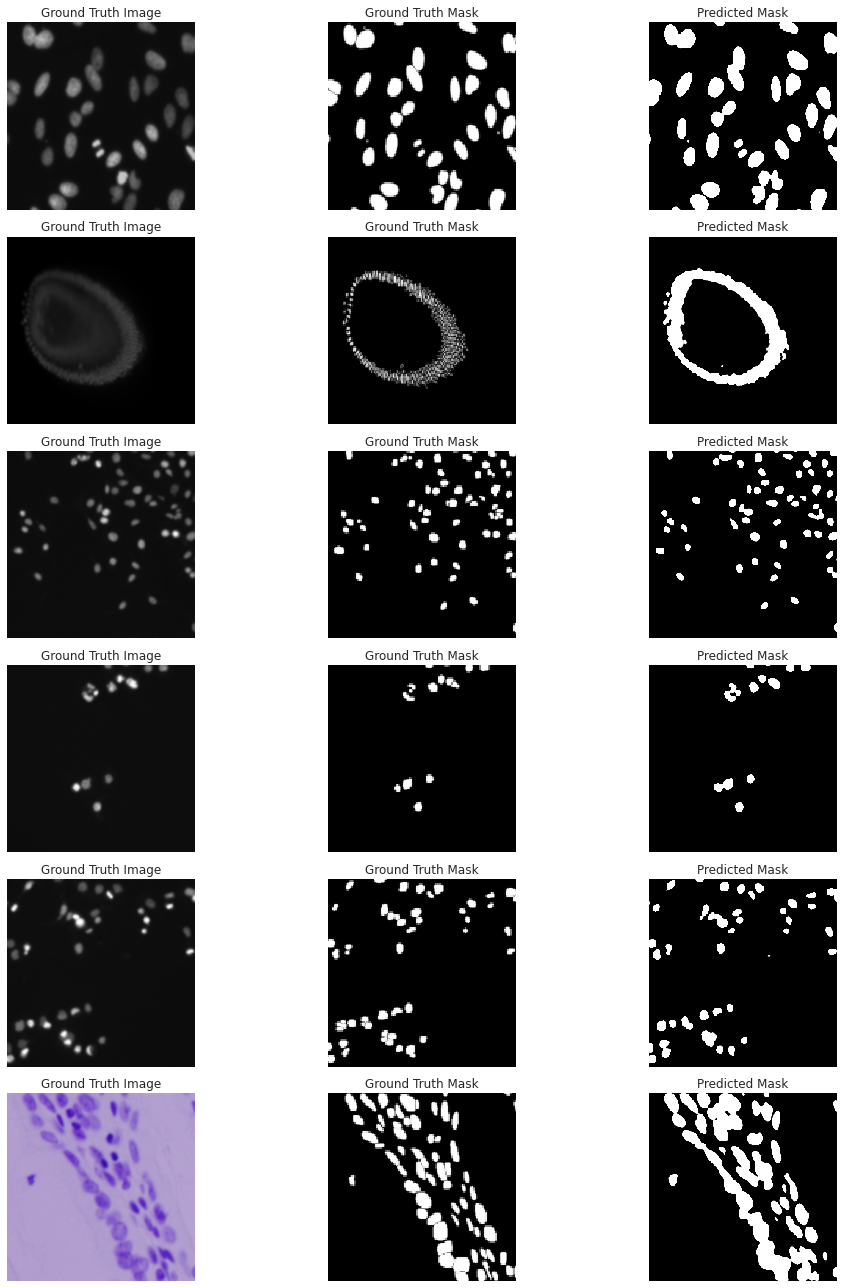

In [29]:
visualize_predict(model, 6)